## Trabajo Fin de Grado
### Gestor de Quirófanos
### Implementación de Algoritmo Genético para asignación de quirófanos

#### Autor: Jesús García Armario

In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import sys
sys.path.append('../')
from Heuristicas.Utils import Quirofano, ActoQuirurgico, Heuristicas
import random
import math
import matplotlib.pyplot as plt

In [2]:
# Importamos el listado preprocesado de una especialidad para las pruebas
filename = '..\\..\\Datos\\Listados_Preprocesados\\ListadoInterv_Preprocesado_MAXILOFACIAL.xlsx'
df = pd.read_excel(filename)
# Seleccionamos una muestra aleatoria de 100 pacientes
df = df.sample(n=100, random_state=1)
# Nos quedamos sólo con el NHC, Ponderación y duración
df = df[['NHC', 'PONDERACIÓN', 'DURACIÓN']]
# Sumamos a la duración 25 minutos por paciente para tener en cuenta el tiempo de preparación
df['DURACIÓN'] = df['DURACIÓN'] + 25
ventana = 30
# Dividimos la duración entre la ventana y redondeamos hacia arriba
df['DURACIÓN'] = df['DURACIÓN'].apply(lambda x: math.ceil(x/ventana))
# Creamos un set de actos quirúrgicos
actos_pendientes = list()
i = 0
for elemento in df.itertuples():
    actos_pendientes.append(ActoQuirurgico(i, elemento[3], elemento[1], elemento[2]))
    i += 1

In [3]:
# Definimos un cromosoma como una lista de tamaño N
# donde N es el número de slots temporales disponibles
# El ID de la operación ocupará la posición del slot temporal o 'V' si no se ha asignado
# El cromosoma se codifica como una lista de enteros
# Con separadores representados por caracteres especiales, siendo 'A' el separador de quirófanos
# y 'B' el separador de días
def cromosomaAleatorio(tiempos, quirofanos, dias, actos_pendientes):
    actos = actos_pendientes.copy()
    cromosoma = []
    # Creamos un cromosoma aleatorio
    for i in range(dias):
        for j in range(quirofanos):
            T = tiempos
            while T > 0:
                if len(actos) == 0:
                    cromosoma.append('V')
                    T -= 1
                else:
                    acto = random.choice(actos)
                    intentos = 0
                    while acto.getDuracion() > T:
                        acto = random.choice(actos)
                        intentos += 1
                        if intentos > len(actos):
                            cromosoma.append('V')
                            T -= 1
                            break
                    cromosoma.append(acto.getId())
                    actos.remove(acto)
                    T -= acto.getDuracion()
            cromosoma.append('A')
        cromosoma.append('B')
    return cromosoma

In [4]:
# Definimos al individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("cromosoma", cromosomaAleatorio, tiempos=16, quirofanos=3, dias=5, actos_pendientes=actos_pendientes)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.cromosoma)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [5]:
# Variables globales
# Definimos la función de fitness
def evaluar(individual, tiempos, quirofanos, dias, actos_pendientes):
    if not validar(individual, tiempos, actos_pendientes):
        return (distance(individual, tiempos, actos_pendientes)),
    # Calculamos el fitness como la suma de las ponderaciones de los actos quirúrgicos
    fitness = 0
    tiempo_quirofano = 0
    huecos_vacios = 0
    # Calculamos el fitness
    for elemento in individual:
        if elemento == 'A':
            if tiempo_quirofano>0:
                huecos_vacios += tiempos/tiempo_quirofano
            else:
                huecos_vacios += tiempos
            continue
        if elemento == 'B':
            continue
        if elemento == 'V':
            tiempo_quirofano += 0
            continue
        tiempo_quirofano += actos_pendientes[elemento].getDuracion()
        fitness += actos_pendientes[elemento].getPrioridad()
    return (huecos_vacios/fitness),

# Definimos la función de validez
def validar(individual, tiempos, actos_pendientes):
    # Comprobamos que la duración de las intervenciones no supera el tiempo disponible
    tiempo_quirofano = 0
    for elemento in individual:
        if elemento == 'A' or elemento == 'B':
            tiempo_quirofano = 0
            continue
        if elemento == 'V':
            tiempo_quirofano += 0
            continue
        tiempo_quirofano += actos_pendientes[elemento].getDuracion()
        if tiempo_quirofano > (tiempos+1):
            return False
    return True

def distance(individual,tiempos,actos_pendientes):
    # Calculamos la distancia entre los actos quirúrgicos
    dist = 0
    tiempo_quirofano = 0
    for elemento in individual:
        if elemento == 'A' or elemento == 'B':
            tiempo_quirofano = 0
            continue
        if elemento == 'V':
            tiempo_quirofano += 0
            continue
        tiempo_quirofano += actos_pendientes[elemento].getDuracion()
        if tiempo_quirofano > (tiempos+1):
            dist += 1
    return dist


In [6]:
def cruce(ind1, ind2):
    # Obtenemos una copia de los padres
    hijo1 = ind1.copy()
    hijo2 = ind2.copy()
    padre1 = ind1.copy()
    padre2 = ind2.copy()
    # Eliminamos los separadores de los padres
    padre1 = [i for i in ind1 if i!='A' and i!='B']
    padre2 = [i for i in ind2 if i!='A' and i!='B']
    # Selecccionamos dos puntos de cruces aleatorios
    punto1 = random.randint(0, len(ind1)-1)
    while ind1[punto1] == 'A' and ind1[punto1] == 'B':
        punto1 = random.randint(0, len(ind1)-1)
    punto2 = random.randint(0, len(ind1)-1)
    while ind1[punto2] == 'A' and ind1[punto2] == 'B' and punto2 == punto1:
        punto2 = random.randint(0, len(ind1)-1)
    punto3 = random.randint(0, len(ind2)-1)
    while ind2[punto3] == 'A' and ind2[punto3] == 'B':
        punto3 = random.randint(0, len(ind2)-1)
    punto4 = random.randint(0, len(ind2)-1)
    while ind2[punto4] == 'A' and ind2[punto4] == 'B' and punto4 == punto3:
        punto4 = random.randint(0, len(ind2)-1)
    # Añadimos los genes del padre 2 al hijo 1 hasta la región de cruce
    if punto1>punto2:
        punto = punto1
        punto1 = punto2
        punto2 = punto
    if punto3>punto4:
        punto = punto3
        punto3 = punto4
        punto4 = punto
    for i in range(len(hijo1)):
        if i < punto1 or i > punto2:
            if hijo1[i] == 'A' or hijo1[i] == 'B':
                continue
            elif len(padre2) == 0:
                break
            hijo1[i] = padre2.pop(0)
    # Añadimos los genes del padre 1 al hijo 2 hasta la región de cruce
    for i in range(len(hijo2)):
        if i < punto3 or i > punto4:
            if hijo2[i] == 'A' or hijo2[i] == 'B':
                continue
            elif len(padre1) == 0:
                break
            hijo2[i] = padre1.pop(0)
    return hijo1, hijo2
def mutacion(individual):
    # Calculamos los índices posibles de intercambio
    indices = [i for i in range(len(individual)) if individual[i] != 'A' and individual[i] != 'B']
    # Seleccionamos dos índices aleatorios
    indices = random.choices(indices, k=2)
    # Intercambiamos los valores
    individual[indices[0]], individual[indices[1]] = individual[indices[1]], individual[indices[0]]
    return individual

In [7]:
toolbox.register("evaluate", evaluar, tiempos=16, quirofanos=3, dias=5, actos_pendientes=actos_pendientes)
toolbox.register("mate", cruce)
toolbox.register("mutate", mutacion)
toolbox.register("select", tools.selTournament, tournsize=3)

In [8]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean) 
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max) 

In [9]:
# Definimos el algoritmo genético
def algoritmo_genetico(poblacion, probabilidad_cruce, probabilidad_mutacion, numero_generaciones):
    # Evaluamos la población
    fitnesses = list(map(toolbox.evaluate, poblacion))
    for ind, fit in zip(poblacion, fitnesses):
        ind.fitness.values = fit
    # Inicializamos las estadísticas
    record = stats.compile(poblacion)
    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + (stats.fields if stats else [])
    # Guardamos las estadísticas
    logbook.record(gen=0, evals=len(poblacion), **record)
    print(logbook.stream)
    # Iniciamos contador de generaciones sin mejora
    contador = 0
    hof = tools.HallOfFame(1)
    hof.update(poblacion)
    # Ejecutamos el algoritmo genético
    for g in range(1, numero_generaciones):
        # Seleccionamos a la población
        poblacion = toolbox.select(poblacion, len(poblacion))
        # Clonamos a los individuos
        hijos = list(map(toolbox.clone, poblacion))
        # Aplicamos el cruce
        for hijo1, hijo2 in zip(hijos[::2], hijos[1::2]):
            if random.random() < probabilidad_cruce:
                toolbox.mate(hijo1, hijo2)
                del hijo1.fitness.values
                del hijo2.fitness.values
        # Aplicamos la mutación
        for hijo in hijos:
            if random.random() < probabilidad_mutacion:
                toolbox.mutate(hijo)
                del hijo.fitness.values
        # Evaluamos a los individuos con fitness inválido
        invalid_ind = [ind for ind in hijos if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        # Reemplazamos a la población
        poblacion[:] = hijos
        # Guardamos las estadísticas
        record = stats.compile(poblacion)
        logbook.record(gen=g, evals=len(poblacion), **record)
        print(logbook.stream)
        # Comprobamos si el mejor individuo ha mejorado
        if hof[0].fitness.values[0] > record['min']:
            contador = 0
        else:
            contador += 1
        hof.update(poblacion)
        # Si no ha mejorado en 50 generaciones, paramos
        if contador == 100:
            break
    return poblacion, logbook, hof

In [10]:
poblacion = toolbox.population(n=200)
# Cargamos el algoritmo genético
poblacion, logbook, hof = algoritmo_genetico(poblacion, probabilidad_cruce=0.85, probabilidad_mutacion=0.15, numero_generaciones=1000)

gen	evals	avg    	std    	min       	max
0  	200  	3.62007	1.71613	0.00234952	9  
1  	200  	2.38519	1.21074	0.00234952	5  
2  	200  	1.44557	1.12041	0.00234952	5  
3  	200  	0.621344	0.764156	0.00234952	3  
4  	200  	0.177091	0.451269	0.00232968	3  
5  	200  	0.0922079	0.362633	0.00232968	2  
6  	200  	0.112196 	0.46628 	0.00232968	3  
7  	200  	0.157123 	0.52945 	0.00232929	3  
8  	200  	0.0821898	0.336526	0.00232156	3  
9  	200  	0.097171 	0.381527	0.00226605	3  
10 	200  	0.127121 	0.422901	0.00232156	2  
11 	200  	0.127107 	0.422905	0.00226632	3  
12 	200  	0.122162 	0.463769	0.00226632	3  
13 	200  	0.142099 	0.489707	0.00226632	3  
14 	200  	0.172036 	0.500408	0.00226632	3  
15 	200  	0.127097 	0.43457 	0.002263  	3  
16 	200  	0.177034 	0.586228	0.002263  	4  
17 	200  	0.182009 	0.553965	0.002263  	3  
18 	200  	0.102119 	0.423765	0.002263  	3  
19 	200  	0.142061 	0.489718	0.00225659	3  
20 	200  	0.0821054	0.305391	0.00225659	2  
21 	200  	0.122059 	0.418457	0.00225659	3  
22

In [11]:
print("Mejor individuo: ", hof[0])
print("Fitness del mejor: ", hof[0].fitness.values[0])

Mejor individuo:  [34, 88, 44, 'A', 79, 1, 21, 30, 57, 38, 68, 'A', 10, 64, 9, 15, 39, 'V', 23, 'A', 'B', 58, 91, 35, 'A', 96, 70, 0, 13, 51, 56, 48, 'A', 8, 59, 5, 62, 2, 33, 'A', 'B', 24, 92, 76, 53, 4, 82, 37, 'A', 99, 93, 7, 'A', 22, 27, 95, 81, 'A', 'B', 60, 46, 87, 50, 89, 47, 'A', 67, 78, 84, 'V', 29, 'A', 6, 80, 43, 77, 'A', 'B', 49, 31, 85, 'A', 75, 41, 19, 'V', 'A', 'V', 32, 25, 90, 'A', 'B']
Fitness del mejor:  0.002233459964991746


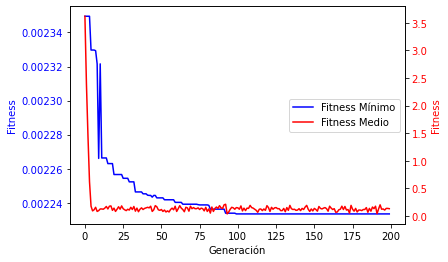

In [12]:
def representaAlgoritmoGenetico(logbook):
    # Representamos el logbook
    gen = logbook.select("gen")
    fit_mins = logbook.select("min")
    fit_maxs = logbook.select("max")
    fit_averages = logbook.select("avg")
    fig, ax1 = plt.subplots()
    line1 = ax1.plot(gen, fit_mins, "b-", label="Fitness Mínimo")
    ax1.set_xlabel("Generación")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")
    ax2 = ax1.twinx()
    line2 = ax2.plot(gen, fit_averages, "r-", label="Fitness Medio")
    ax2.set_ylabel("Fitness", color="r")
    for tl in ax2.get_yticklabels():
        tl.set_color("r")
    lns = line1 + line2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="center right")
    plt.show()

representaAlgoritmoGenetico(logbook)

Incluimos las heurísticas como parte de la población inicial

In [13]:
# Función que traduce el fenotipo de la heurística a un cromosoma
def fenotipoACromosoma(fenotipo):
    dias = len(fenotipo)
    quirofanos = len(fenotipo[0])
    cromosoma = []
    for i in range(dias):
        for j in range(quirofanos):
            for acto in fenotipo[i][j].getActos():
                cromosoma.append(acto.getId())
            cromosoma.append('A')
        cromosoma.append('B')
    return cromosoma

modelo_heur = Heuristicas(actos_pendientes, 3, 5, 16)
asignacionLPT, _ = modelo_heur.ejecutaHeuristica()
asignacionLPTEDD, _ = modelo_heur.ejecutaHeuristica("LPTEDD")

In [14]:
toolbox.register("heuristicaLPT", fenotipoACromosoma,asignacionLPT)
toolbox.register("heuristicaLPTEDD", fenotipoACromosoma,asignacionLPTEDD)
toolbox.register("indModelo", tools.initIterate, creator.Individual, toolbox.heuristicaLPT)
toolbox.register("indModeloDos", tools.initIterate, creator.Individual, toolbox.heuristicaLPTEDD)

In [15]:
ind = toolbox.indModelo()

In [16]:
# Iniciamos población aleatoria
poblacion = toolbox.population(n=200)
# Sustituimos a dos individuos aleatorios por los individuos de las heurísticas
poblacion[random.randint(0, len(poblacion)-1)] = toolbox.indModelo()
poblacion[random.randint(0, len(poblacion)-1)] = toolbox.indModeloDos()
# Cargamos el algoritmo genético
poblacion, logbook, hof = algoritmo_genetico(poblacion, probabilidad_cruce=0.85, probabilidad_mutacion=0.15, numero_generaciones=1000)

gen	evals	avg    	std    	min       	max
0  	200  	3.98012	1.74604	0.00252805	10 
1  	200  	2.68025	1.36977	0.00252805	7  
2  	200  	1.72057	1.19149	0.00252805	5  
3  	200  	0.781331	0.859957	0.00252805	4  
4  	200  	0.352052	0.711383	0.00252441	5  
5  	200  	0.0874157	0.383881	0.00252441	4  
6  	200  	0.132301 	0.450002	0.00252441	3  
7  	200  	0.0973508	0.381482	0.00252188	3  
8  	200  	0.112338 	0.444282	0.00251911	4  
9  	200  	0.072399 	0.338769	0.00245092	3  
10 	200  	0.0973708	0.418957	0.00245092	3  
11 	200  	0.102342 	0.399415	0.00244873	3  
12 	200  	0.162308 	0.603044	0.002433  	4  
13 	200  	0.087329 	0.342607	0.002433  	2  
14 	200  	0.132222 	0.415359	0.002433  	2  
15 	200  	0.127218 	0.410878	0.002433  	2  
16 	200  	0.127259 	0.478342	0.002433  	3  
17 	200  	0.127206 	0.410882	0.00243136	2  
18 	200  	0.112276 	0.444297	0.00243136	3  
19 	200  	0.122226 	0.418409	0.00242036	2  
20 	200  	0.122213 	0.418413	0.00242036	3  
21 	200  	0.182139 	0.580371	0.00242036	5  
22

Mejor individuo:  [12, 82, 74, 86, 5, 35, 80, 'A', 2, 65, 13, 49, 'A', 56, 84, 1, 37, 8, 50, 21, 'A', 'B', 83, 32, 46, 'V', 17, 'A', 11, 57, 0, 61, 15, 'A', 39, 72, 22, 43, 40, 'V', 28, 'A', 'B', 10, 66, 93, 'A', 44, 4, 92, 23, 62, 'V', 73, 'A', 69, 95, 70, 99, 79, 'A', 'B', 55, 58, 63, 42, 'A', 89, 3, 'V', 60, 'A', 16, 45, 91, 85, 30, 'A', 'B', 24, 31, 76, 38, 'A', 51, 78, 77, 19, 'A', 18, 88, 90, 'A', 'B']
Fitness del mejor:  0.002402467901605811


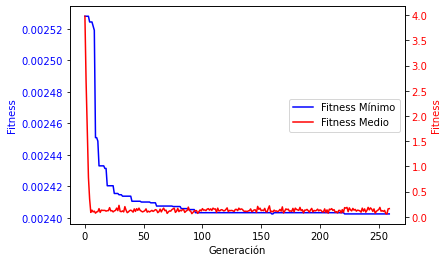

In [18]:
print("Mejor individuo: ", hof[0])
print("Fitness del mejor: ", hof[0].fitness.values[0])
representaAlgoritmoGenetico(logbook)